<a href="https://colab.research.google.com/github/EternalVoid6/BNN-space-debris-classifier/blob/main/BNN_IMC_InProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1: Project Setup and Installations**

In [1]:
# Install the skyfield library for astronomical and satellite calculations
!pip install skyfield

# Import all necessary libraries for both experiments
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import numpy as np
from tqdm import tqdm # For progress bars

# Import libraries for data loading and visualization
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set a style for our plots
plt.style.use('seaborn-v0_8-whitegrid')
print("All libraries installed and imported successfully!...")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 kB 22.9 MB/s eta 0:00:00
All libraries installed and imported successfully!...


**2: BNN Core Definitions**

In [2]:
class Binarize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return torch.where(input >= 0, torch.ones_like(input), torch.ones_like(input) * -1)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output
binarize = Binarize.apply

class BinarizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        super(BinarizedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
    def forward(self, x):
        return F.conv2d(x, binarize(self.conv.weight), stride=self.conv.stride, padding=self.conv.padding)

class BinarizedLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(BinarizedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
    def forward(self, x):
        return F.linear(x, binarize(self.linear.weight))

print("BNN core components defined.")

BNN core components defined.


**Experiment 1: Benchmarking on the MNIST Dataset**

**3: MNIST - Model Definition**

In [3]:
# EXPERIMENT 1: MNIST

# A BNN Model specifically for the 10 classes of MNIST
class BNN_Model_MNIST(nn.Module):
    def __init__(self):
        super(BNN_Model_MNIST, self).__init__()
        self.conv1 = BinarizedConv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = BinarizedConv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        # The final layer has 10 outputs for digits 0-9
        self.fc1 = BinarizedLinear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = binarize(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = binarize(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        return x

print("BNN Model for MNIST defined.")

BNN Model for MNIST defined.


**4: MNIST - Data Loading and Preprocessing**

In [4]:
# Define the transformation to binarize the input images
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    # Binarize the image: pixels > 0.5 become 1, else -1
    lambda x: x.gt(0.5).float() * 2 - 1
])

# Download and load the training data (will be saved in a './data' folder)
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
trainloader_mnist = DataLoader(trainset_mnist, batch_size=128, shuffle=True)

# Download and load the test data
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
testloader_mnist = DataLoader(testset_mnist, batch_size=100, shuffle=False)

print("\nMNIST dataset is ready.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.73MB/s]


MNIST dataset is ready.


**5: MNIST - Training and Evaluation**

In [5]:
# Setup for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_mnist = BNN_Model_MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)
epochs = 5 # Can be increased for higher accuracy
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

print(f"Using device: {device}")
print("\nStarting MNIST Training... ")

# Training Loop
for epoch in range(epochs):
    model_mnist.train()
    for i, (inputs, labels) in enumerate(tqdm(trainloader_mnist, desc=f"Epoch {epoch+1}/{epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_mnist(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"End of Epoch {epoch+1}, learning rate: {scheduler.get_last_lr()[0]}")

print("Finished Training!")

# Evaluation Loop
correct = 0
total = 0
with torch.no_grad():
    model_mnist.eval()
    for images, labels in testloader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model_mnist(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'\nAccuracy of the BNN on the 10000 test images: {accuracy:.2f} %')

Using device: cpu

Starting MNIST Training... 


Epoch 1/5: 100%|██████████| 469/469 [01:02<00:00,  7.45it/s]


End of Epoch 1, learning rate: 0.001


Epoch 2/5: 100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


End of Epoch 2, learning rate: 0.0001


Epoch 3/5: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s]


End of Epoch 3, learning rate: 0.0001


Epoch 4/5: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s]


End of Epoch 4, learning rate: 1e-05


Epoch 5/5: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s]


End of Epoch 5, learning rate: 1e-05
Finished Training!

Accuracy of the BNN on the 10000 test images: 94.34 %


**6: MNIST - Visualize Results**

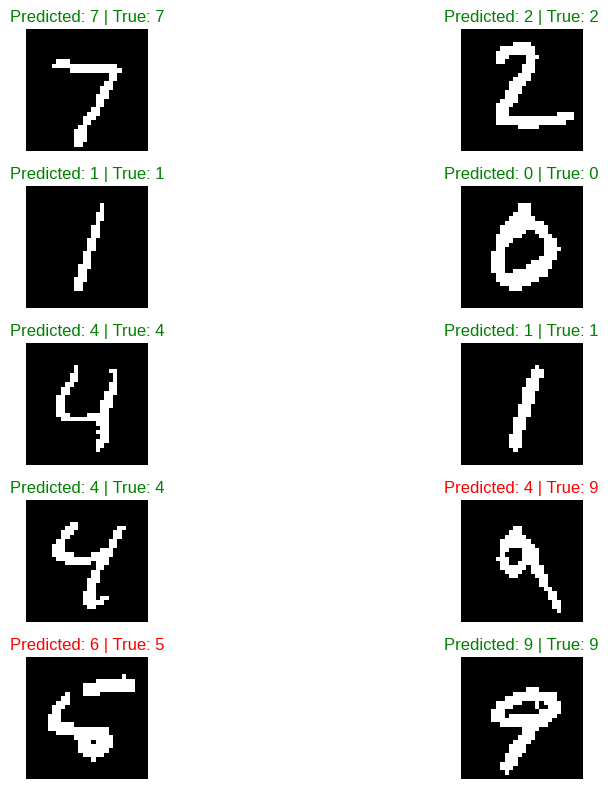

In [6]:
def visualize_mnist_predictions(model, dataloader, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                # Set title color based on correctness
                color = "green" if preds[j] == labels[j] else "red"
                ax.set_title(f'Predicted: {preds[j]} | True: {labels[j]}', color=color)

                # Show the binarized input the model sees
                img_display = inputs.cpu().data[j]
                plt.imshow(img_display.squeeze(), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return
    model.train(mode=was_training)

visualize_mnist_predictions(model_mnist, testloader_mnist)

**Experiment 2: Real-World Application - Space Debris Classification**

**7: Space Debris - Model Definition**

In [7]:
# A BNN Model specifically for the 2 classes of our debris problem
class BNN_Model_Debris(nn.Module):
    def __init__(self):
        super(BNN_Model_Debris, self).__init__()
        self.conv1 = BinarizedConv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = BinarizedConv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        # The final layer has 2 outputs: "Safe" and "Debris"
        self.fc1 = BinarizedLinear(64 * 7 * 7, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = binarize(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = binarize(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        return x

print("BNN Model for Space Debris defined.")

BNN Model for Space Debris defined.


**8: Space Debris - Data Loading and Generation**

In [11]:
from skyfield.api import load

def create_dataset_from_tle(satellites, num_samples, img_size=28):
    images, labels = [], []
    ts = load.timescale()
    now = ts.now()
    time_offsets = np.random.uniform(0, 1, num_samples)

    print(f"Generating {num_samples} samples from TLE data...")
    for i in tqdm(range(num_samples)):
        t = ts.utc(now.utc.year, now.utc.month, now.utc.day, now.utc.hour + time_offsets[i]*24)
        geocentric = [sat.at(t) for sat in satellites]
        center_sat = satellites[np.random.randint(len(satellites))]
        sensor_map = np.zeros((img_size, img_size))
        has_debris = False

        for j, sat in enumerate(satellites):
            if center_sat.model.satnum == sat.model.satnum: continue
            distance = np.linalg.norm(geocentric[j].position.km - center_sat.at(t).position.km)
            if distance < 3000: # Simplified distance threshold (3000 km)
                px, py = np.random.randint(0, img_size), np.random.randint(0, img_size)
                sensor_map[px, py] = 1.0
                if "DEB" in sat.name or "R/B" in sat.name:
                    has_debris = True

        binarized_image = (sensor_map > 0.5).astype(np.float32) * 2 - 1
        images.append(binarized_image)
        labels.append(1 if has_debris else 0)

    return TensorDataset(torch.FloatTensor(np.array(images)).unsqueeze(1), torch.LongTensor(np.array(labels)))

print("Downloading satellite TLE data...")
stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
debris_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=debris&FORMAT=tle'
satellites = load.tle_file(stations_url, reload=True)
debris = load.tle_file(debris_url, reload=True)
all_objects = satellites + debris
print(f"Loaded {len(all_objects)} total objects.")

# Generate Datasets and DataLoaders
train_dataset_debris = create_dataset_from_tle(all_objects, num_samples=5000)
test_dataset_debris = create_dataset_from_tle(all_objects, num_samples=1000)
trainloader_debris = DataLoader(train_dataset_debris, batch_size=64, shuffle=True)
testloader_debris = DataLoader(test_dataset_debris, batch_size=100, shuffle=False)
print("\nDebris dataset is ready.")

[#################################] 100% gp.php
[#################################] 100% gp.php


Loaded 12894 total objects.
Generating 5000 samples from TLE data...


100%|██████████| 5000/5000 [1:24:39<00:00,  1.02s/it]


Generating 1000 samples from TLE data...


100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]


Debris dataset is ready.


**9: Space Debris - Training and Evaluation**

In [12]:
# Setup for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_debris = BNN_Model_Debris().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_debris.parameters(), lr=0.001)
epochs = 15
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

print(f"Using device: {device}")
print("\nStarting Space Debris Training... 🛰️")

# Training Loop
for epoch in range(epochs):
    model_debris.train()
    for i, (inputs, labels) in enumerate(tqdm(trainloader_debris, desc=f"Epoch {epoch+1}/{epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_debris(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"End of Epoch {epoch+1}, learning rate: {scheduler.get_last_lr()[0]}")

print("Finished Training!")

# Evaluation Loop
correct = 0
total = 0
with torch.no_grad():
    model_debris.eval()
    for images, labels in testloader_debris:
        images, labels = images.to(device), labels.to(device)
        outputs = model_debris(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'\nAccuracy of the BNN on the generated TLE test images: {accuracy:.2f} %')

Using device: cpu

Starting Space Debris Training... 🛰️


Epoch 1/15: 100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


End of Epoch 1, learning rate: 0.001


Epoch 2/15: 100%|██████████| 79/79 [00:04<00:00, 15.91it/s]


End of Epoch 2, learning rate: 0.001


Epoch 3/15: 100%|██████████| 79/79 [00:05<00:00, 15.27it/s]


End of Epoch 3, learning rate: 0.001


Epoch 4/15: 100%|██████████| 79/79 [00:05<00:00, 15.51it/s]


End of Epoch 4, learning rate: 0.001


Epoch 5/15: 100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


End of Epoch 5, learning rate: 0.0001


Epoch 6/15: 100%|██████████| 79/79 [00:05<00:00, 15.16it/s]


End of Epoch 6, learning rate: 0.0001


Epoch 7/15: 100%|██████████| 79/79 [00:05<00:00, 14.01it/s]


End of Epoch 7, learning rate: 0.0001


Epoch 8/15: 100%|██████████| 79/79 [00:05<00:00, 15.15it/s]


End of Epoch 8, learning rate: 0.0001


Epoch 9/15: 100%|██████████| 79/79 [00:05<00:00, 15.29it/s]


End of Epoch 9, learning rate: 0.0001


Epoch 10/15: 100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


End of Epoch 10, learning rate: 1e-05


Epoch 11/15: 100%|██████████| 79/79 [00:05<00:00, 14.76it/s]


End of Epoch 11, learning rate: 1e-05


Epoch 12/15: 100%|██████████| 79/79 [00:05<00:00, 13.93it/s]


End of Epoch 12, learning rate: 1e-05


Epoch 13/15: 100%|██████████| 79/79 [00:04<00:00, 16.17it/s]


End of Epoch 13, learning rate: 1e-05


Epoch 14/15: 100%|██████████| 79/79 [00:05<00:00, 14.77it/s]


End of Epoch 14, learning rate: 1e-05


Epoch 15/15: 100%|██████████| 79/79 [00:04<00:00, 16.45it/s]


End of Epoch 15, learning rate: 1.0000000000000002e-06
Finished Training!

Accuracy of the BNN on the generated TLE test images: 60.60 %


**10: Space Debris - Visualize Results**

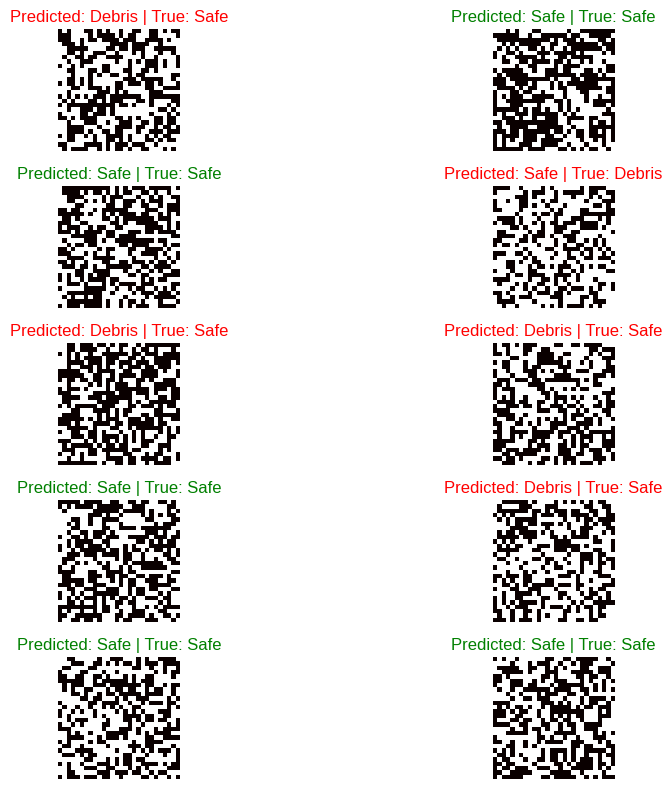

In [13]:
def visualize_debris_predictions(model, dataloader, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))
    class_names = ['Safe', 'Debris']

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                pred_name = class_names[preds[j]]
                true_name = class_names[labels[j]]
                color = "green" if pred_name == true_name else "red"
                ax.set_title(f'Predicted: {pred_name} | True: {true_name}', color=color)

                img_display = inputs.cpu().data[j]
                plt.imshow(img_display.squeeze(), cmap='hot') # 'hot' colormap looks like a sensor

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return
    model.train(mode=was_training)

visualize_debris_predictions(model_debris, testloader_debris)